In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Build-Model'
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import os
path_model = os.path.join(path,"weight")

def load_model(path_model):
  model = cv2.dnn.readNetFromTorch(path_model)
  return model

encoder = load_model(path_model)

Conver bob image

In [ ]:
import cv2
def _blobImage(image, out_size = (300, 300), scaleFactor = 1.0, mean = (104.0, 177.0, 123.0)):
  """
  input:
    image: ma trận RGB của ảnh input
    out_size: kích thước ảnh blob
  return:
    imageBlob: ảnh blob
  """
  # Chuyển sang blobImage để tránh ảnh bị nhiễu sáng
  imageBlob = cv2.dnn.blobFromImage(image, 
                                    scalefactor=scaleFactor,   # Scale image
                                    size=out_size,  # Output shape
                                    mean=mean,  # Trung bình kênh theo RGB
                                    swapRB=False,  # Trường hợp ảnh là BGR thì set bằng True để chuyển qua RGB
                                    crop=False)
  return imageBlob

Trích suất các khuôn mặt

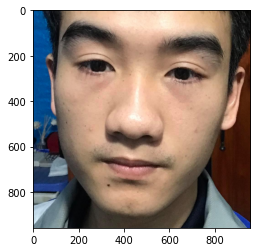

In [ ]:
from face_recognition import face_locations 
import matplotlib.pyplot as plt

def read_image(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

def extract_bbox(image, single = True):
  bboxs = face_locations(image)
  if len(bboxs) == 0:
    return None
  if single:
    bbox = bboxs[0]
    return bbox
  else:
    return bboxs

def extract_face(image, bbox, face_scale_thres = (20,20)):
  h,w = image.shape[:2]
  try:
    (startY, startX, endY, endX) = bbox
  except:
    return None
  
  minX, maxX = min(startX, endX), max(startX, endX)
  minY, maxY = min(startY, endY), max(startY, endY)
  face = image[minY:maxY, minX:maxX].copy()
  #extract the face ROI and grab the ROI dimensions
  (fH, fW) = face.shape[:2]
  if fW < face_scale_thres[0] or fH < face_scale_thres[1]:
    return None 
  else:
    return face

#test
path_image_test = '/content/gdrive/MyDrive/Build-Model/data/Toan/155835556_4523847210995503_7498832265894173008_n.jpg'
image_test = read_image(path_image_test)
bbox = extract_bbox(image_test)
face = extract_face(image_test,bbox)
plt.imshow(face)

Trich xuat toan bo cac khuon mat trong dataset

In [ ]:
from imutils import paths 
DATASET_PATH = "/content/gdrive/MyDrive/Build-Model/data"

def _model_processing(face_scale_thres = (20, 20)):
  """
  face_scale_thres: Ngưỡng (W, H) để chấp nhận một khuôn mặt.
  """
  image_links = list(paths.list_images(DATASET_PATH))
  images_file = [] 
  y_labels = []
  faces = []
  total = 0
  for image_link in image_links:
    split_img_links = image_link.split("/")
    # Lấy nhãn của ảnh
    name = split_img_links[-2] 
    # Đọc ảnh
    image = read_image(image_link)
    (h, w) = image.shape[:2]
    # Detect vị trí các khuôn mặt trên ảnh. Gỉa định rằng mỗi bức ảnh chỉ có duy nhất 1 khuôn mặt của chủ nhân classes.
    bbox = extract_bbox(image, single=True)
    # print(bbox_ratio)
    if bbox is not None:
      # Lấy ra face
      face = extract_face(image, bbox, face_scale_thres = (20, 20))
      if face is not None:
        faces.append(face)
        y_labels.append(name)
        images_file.append(image_links)
        total += 1
      else:
        next
  print("Total bbox face extracted: {}".format(total))
  return faces, y_labels, images_file

faces, y_labels, images_file = _model_processing()

Total bbox face extracted: 28


In [ ]:
import pickle

def _save_pickle(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
  return obj

_save_pickle(faces, "./faces.pkl")
_save_pickle(y_labels, "./y_labels.pkl")
_save_pickle(images_file, "./images_file.pkl")


In [ ]:
def processing_face(faces):
  emb_vecs = []
  for face in faces:
    faceBlob = _blobImage(face, out_size = (96,96), scaleFactor=1/255.0, mean = (0,0,0))
    emb_vecs.append(faceBlob)
  return emb_vecs

In [ ]:
faces = _load_pickle("./faces.pkl")
y_labels = _load_pickle("./y_labels.pkl")

from sklearn.model_selection import train_test_split
ids = np.arange(len(y_labels))

faces = processing_face(faces)

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(np.stack(faces), y_labels, ids, test_size = 0.2, stratify = y_labels)
X_train = np.squeeze(X_train, axis = 1)
X_test = np.squeeze(X_test, axis = 1)
print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))



(22, 3, 96, 96) (6, 3, 96, 96)
22 6


In [ ]:
_save_pickle(id_train, "./id_train.pkl")
_save_pickle(id_test, "./id_test.pkl")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Flatten
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

def _base_network():
  model = VGG16(include_top = True, weights = None)
  dense = Dense(128)(model.layers[-4].output)
  norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))(dense)
  model = Model(inputs = [model.input], outputs = [norm2])
  return model

model = _base_network()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Triplet-semi-hard loss

In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [ ]:
faces = _load_pickle("./faces.pkl")

import cv2

faceResizes = []
for face in faces:
  face_rz = cv2.resize(face, (224,224))
  faceResizes.append(face_rz)
X = np.stack(faceResizes)
X.shape

(28, 224, 224, 3)

In [ ]:
id_train = _load_pickle('./id_train.pkl')
id_test = _load_pickle('./id_test.pkl')

X_train, X_test = X[id_train], X[id_test]

print(X_train.shape)
print(X_test.shape)

(22, 224, 224, 3)
(6, 224, 224, 3)


In [ ]:
gen_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().shuffle(1024).batch(32)
gen_train

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.uint8, tf.string)>

In [ ]:
history = model.fit(gen_train,
                    steps_per_epoch = 50,
                    epochs = 10)

Epoch 1/10
50/50 [==============================] - 24s 462ms/step - loss: 0.6256
Epoch 2/10
50/50 [==============================] - 23s 463ms/step - loss: 3.3850e-04
Epoch 3/10
50/50 [==============================] - 23s 464ms/step - loss: 0.0000e+00
Epoch 4/10
50/50 [==============================] - 23s 466ms/step - loss: 0.0000e+00
Epoch 5/10
50/50 [==============================] - 23s 467ms/step - loss: 0.0000e+00
Epoch 6/10
50/50 [==============================] - 23s 468ms/step - loss: 0.0000e+00
Epoch 7/10
50/50 [==============================] - 23s 470ms/step - loss: 0.0000e+00
Epoch 8/10
50/50 [==============================] - 24s 473ms/step - loss: 0.0000e+00
Epoch 9/10
50/50 [==============================] - 24s 473ms/step - loss: 0.0000e+00
Epoch 10/10
50/50 [==============================] - 24s 472ms/step - loss: 0.0000e+00


In [ ]:
from sklearn.metrics import accuracy_score
X_train_vec = model.predict(X_train)
X_test_vec = model.predict(X_test)
y_preds = []
for vec in X_test_vec:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_vec, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.5


SHOW

In [ ]:
def _normalize_image(image, epsilon=0.000001):
  means = np.mean(image.reshape(-1, 3), axis=0)
  stds = np.std(image.reshape(-1, 3), axis=0)
  image_norm = image - means
  image_norm = image_norm/(stds + epsilon)
  return image_norm

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def _most_similarity(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1]
  label = [labels[idx] for idx in argmax][0]
  return label

<Figure size 1152x576 with 0 Axes>

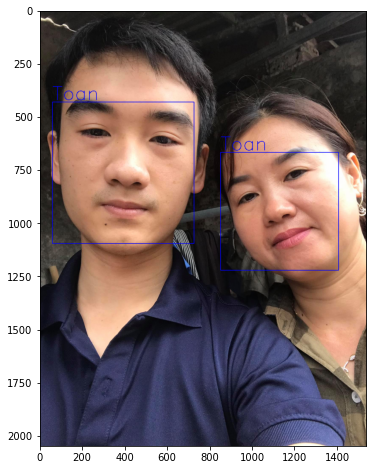

In [ ]:
IMAGE_PREDICT = "/content/gdrive/MyDrive/Build-Model/156345365_227702969099610_9174769425994105781_n.jpg"
image = read_image(IMAGE_PREDICT)
bboxs = extract_bbox(image, single = False)
faces = []
for bbox in bboxs:
  face = extract_face(image, bbox, face_scale_thres = (20, 20))
  faces.append(face)
  face_rz = cv2.resize(face, (224, 224))
  img = face_rz.reshape(1,224,224,3)
  #face_tf = _normalize_image(img)
  face_tf = np.expand_dims(img, axis = 0)
  vec_train  = tf.data.Dataset.from_tensor_slices((face_tf))
  vec = model.predict(vec_train)
  name = _most_similarity(X_train_vec,vec,y_train)
  (startY, startX, endY, endX) = bbox
  minX, maxX = min(startX, endX), max(startX, endX)
  minY, maxY = min(startY, endY), max(startY, endY)
  text = "{}".format(name)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.rectangle(image, (minX, minY), (maxX, maxY), (0, 0, 255), 2)
  cv2.putText(image, text, (minX, y),
      cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
  plt.figure(figsize = (16, 8))

plt.imshow(image)

  


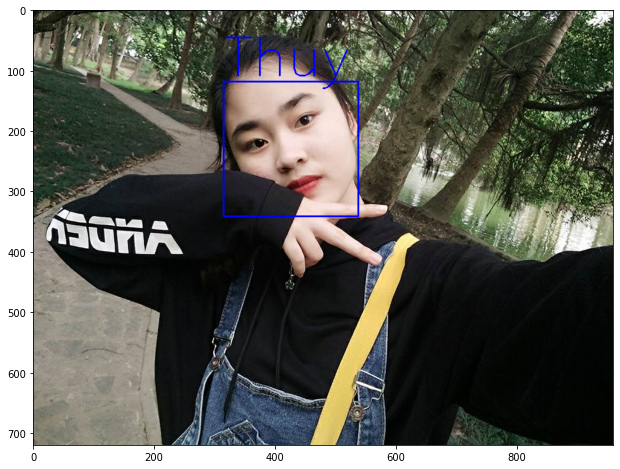

In [ ]:
IMAGE_PREDICT2 = "/content/gdrive/MyDrive/Build-Model/data/Thuy/36137512_2059871424264563_2523697511542030336_n.jpg"
image = read_image(IMAGE_PREDICT2)
bboxs = extract_bbox(image, single = False)
faces = []
for bbox in bboxs:
  face = extract_face(image, bbox, face_scale_thres = (20, 20))
  faces.append(face)
  face_rz = cv2.resize(face, (224, 224))
  img = face_rz.reshape(1,224,224,3)
  face_tf = _normalize_image(img)
  face_tf = np.expand_dims(face_tf, axis = 0)
  vec_train  = tf.data.Dataset.from_tensor_slices((face_tf))
  vec = model.predict(vec_train)
  name = _most_similarity(X_train_vec,vec,y_train)
  (startY, startX, endY, endX) = bbox
  minX, maxX = min(startX, endX), max(startX, endX)
  minY, maxY = min(startY, endY), max(startY, endY)
  text = "{}".format(name)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.rectangle(image, (minX, minY), (maxX, maxY), (0, 0, 255), 2)
  cv2.putText(image, text, (minX, y),
      cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
  plt.figure(figsize = (16, 8))

plt.imshow(image)



#PRE-TRAINED MODEL TOT HON =))